In [1]:
# Essential libraries for data collection
import pandas as pd
import numpy as np
import requests
import yfinance as yf  # For financial data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saketk511/2019-2024-us-stock-market-data")

print("Path to dataset files:", path)

100%|██████████| 155k/155k [00:00<00:00, 504kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/saketk511/2019-2024-us-stock-market-data/versions/1


In [2]:
# Data cleaning template
def clean_data(df):
    # Remove duplicates
    df = df.drop_duplicates()

    # Handle missing values
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Fill numeric with median, categorical with mode
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

    return df

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/colab notebooks/Stock Market Dataset.csv")

# Preprocessing: Convert 'Date' to datetime and set as index with specified format
df["Date"] = pd.to_datetime(df["Date"], format='%d-%m-%Y')
df = df.set_index("Date")

# Select features (X) and target (y)
# Let's use 'Apple_Price', 'Tesla_Price', 'Microsoft_Price' as features and 'S&P_500_Price' as target
X = df[["Apple_Price", "Tesla_Price", "Microsoft_Price"]]
y = df["S&P_500_Price"]

# Convert target and features to numeric, handling non-numeric values
# The prices seem to have commas, so remove them and convert to numeric
for col in X.columns:
    X[col] = X[col].astype(str).str.replace(",", "").astype(float)
y = y.astype(str).str.replace(",", "").astype(float)

# Handle missing values (if any) - fill with mean for numerical columns
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model comparison template
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(n_estimators=100)
}

# Cross-validation comparison
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"{name}: {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")

/tmp/ipython-input-4-3062871506.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str).str.replace(",", "").astype(float)
/tmp/ipython-input-4-3062871506.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str).str.replace(",", "").astype(float)
/tmp/ipython-input-4-3062871506.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Linear Regression: -24963.4288 (+/- 2949.8810)
Random Forest: -4686.0047 (+/- 2196.9408)
XGBoost: -5472.8098 (+/- 2520.9471)


In [5]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# For time series data
tscv = TimeSeriesSplit(n_splits=5)

# For regular data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.model_selection import GridSearchCV

# XGBoost hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Model evaluation
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 57.0496
R²: 0.9911
MAE: 40.9185


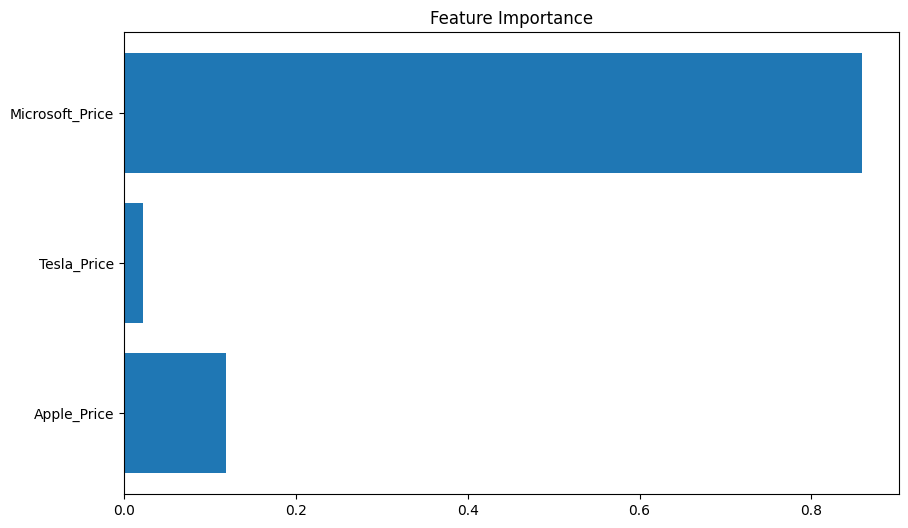

In [8]:
# Feature importance analysis
import matplotlib.pyplot as plt

feature_importance = best_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title('Feature Importance')
plt.show()

In [9]:
# For uncertainty quantification
from sklearn.ensemble import RandomForestRegressor

# Use Random Forest to get prediction intervals
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

# Get individual tree predictions
predictions = np.array([tree.predict(X_test) for tree in rf_model.estimators_])
prediction_intervals = np.percentile(predictions, [2.5, 97.5], axis=0)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [10]:
from sklearn.ensemble import VotingRegressor

# Create ensemble model
ensemble = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('xgb', XGBRegressor(n_estimators=100)),
    ('lr', LinearRegression())
])

ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)

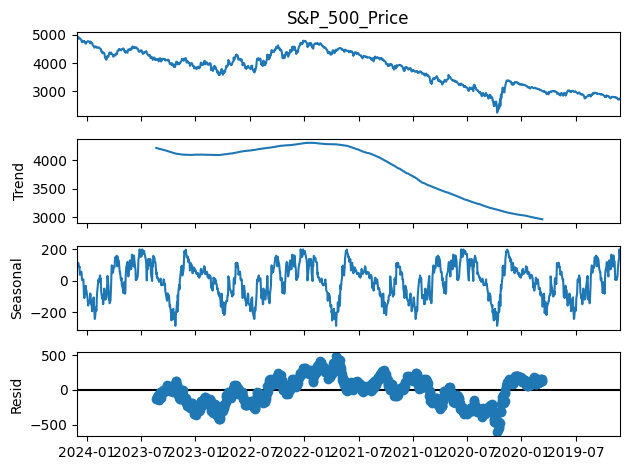

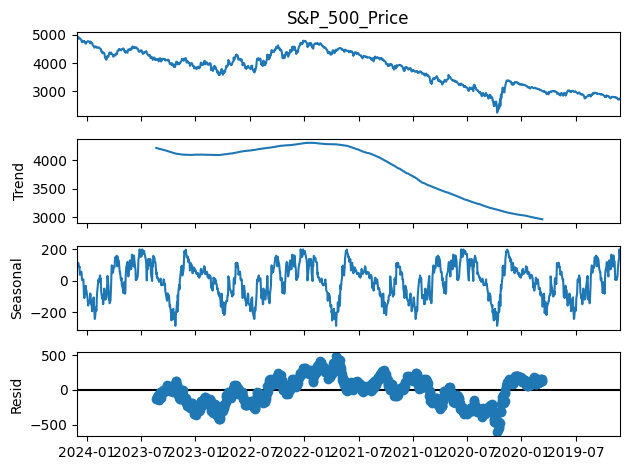

In [11]:
# For time series forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomposition = seasonal_decompose(y, model='additive', period=365)
decomposition.plot()

In [12]:
import joblib
import pickle

# Save the trained model
joblib.dump(best_model, 'predictive_model.pkl')

# Save preprocessing pipeline
# joblib.dump(scaler, 'scaler.pkl') # Removed as scaler was not defined

['predictive_model.pkl']

In [13]:
def make_prediction(new_data):
    # Load models
    model = joblib.load('predictive_model.pkl')
    scaler = joblib.load('scaler.pkl')

    # Preprocess new data
    new_data_scaled = scaler.transform(new_data)

    # Make prediction
    prediction = model.predict(new_data_scaled)

    return prediction

In [14]:
# Model performance report
report = {
    'model_type': 'XGBoost Regressor',
    'training_data_size': len(X_train),
    'test_data_size': len(X_test),
    'features_used': list(X.columns),
    'performance_metrics': {
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae
    },
    'hyperparameters': best_model.get_params(),
    'feature_importance': dict(zip(feature_names, feature_importance))
}

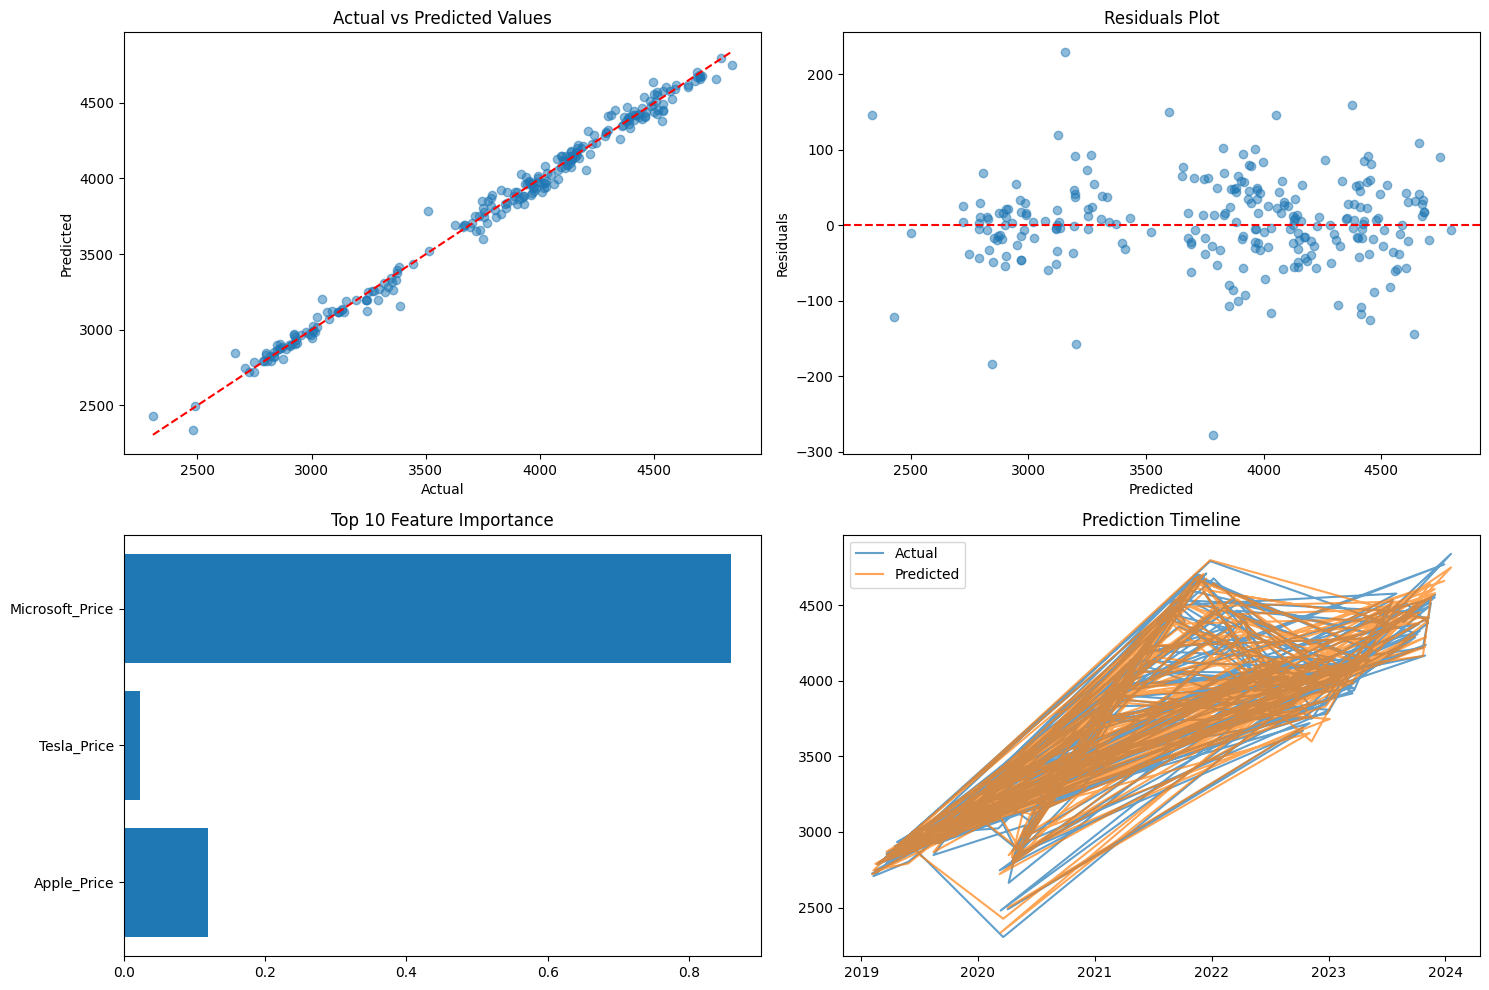

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Actual vs Predicted
axes[0,0].scatter(y_test, y_pred, alpha=0.5)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_xlabel('Actual')
axes[0,0].set_ylabel('Predicted')
axes[0,0].set_title('Actual vs Predicted Values')

# Residuals plot
residuals = y_test - y_pred
axes[0,1].scatter(y_pred, residuals, alpha=0.5)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals Plot')

# Feature importance
axes[1,0].barh(feature_names[:10], feature_importance[:10])
axes[1,0].set_title('Top 10 Feature Importance')

# Prediction timeline
axes[1,1].plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
axes[1,1].plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
axes[1,1].legend()
axes[1,1].set_title('Prediction Timeline')

plt.tight_layout()
plt.show()

In [16]:
def monitor_model_performance(new_data, predictions, actual_values):
    # Calculate drift in predictions
    current_accuracy = r2_score(actual_values, predictions)

    # Alert if performance degrades
    if current_accuracy < 0.8:  # threshold
        print("Model performance degraded - retraining needed")

    return current_accuracy

In [17]:
def retrain_model(new_data_path):
    # Load new data
    new_data = pd.read_csv(new_data_path)

    # Preprocess
    new_data_clean = clean_data(new_data)

    # Retrain model
    model.fit(new_data_clean[feature_columns], new_data_clean[target_column])

    # Save updated model
    joblib.dump(model, 'updated_model.pkl')